## 5. Случайный лес

In [1]:
import numpy as np
import random
import matplotlib

from sklearn import datasets
from sklearn import model_selection

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
%matplotlib inline

light_colors = ListedColormap(['lightcoral', 'lightblue'])
colors = ListedColormap(['red', 'blue'])

In [2]:
random.seed(42)

def get_bootstrap(data, labels, N):
    n_samples = data.shape[0]
    bootstrap = []
    for i in range(N):
        b_data = np.zeros(data.shape)
        b_labels = np.zeros(labels.shape)
        for j in range(n_samples):
            sample_index = random.randint(0, n_samples-1)
            b_data[j] = data[sample_index]
            b_labels[j] = labels[sample_index]
        bootstrap.append((b_data, b_labels))
    return bootstrap

def get_subsample(len_sample):
    sample_indexes = [i for i in range(len_sample)]
    len_subsample = int(np.sqrt(len_sample))
    subsample = []
    random.shuffle(sample_indexes)
    for _ in range(len_subsample):
        subsample.append(sample_indexes.pop())
    return subsample

class Node:
    def __init__(self, index, t, true_branch, false_branch):
        self.index = index
        self.t = t
        self.true_branch = true_branch
        self.false_branch = false_branch

class Leaf:
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        self.prediction = self.predict()
        
    def predict(self):
        classes = {}  
        for label in self.labels:
            if label not in classes:
                classes[label] = 0
            classes[label] += 1
        prediction = max(classes, key=classes.get)
        return prediction
    
def gini(labels):
    classes = {}
    for label in labels:
        if label not in classes:
            classes[label] = 0
        classes[label] += 1
    impurity = 1
    for label in classes:
        p = classes[label] / len(labels)
        impurity -= p ** 2
    return impurity

def quality(left_labels, right_labels, current_gini):
    p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])
    return current_gini - p * gini(left_labels) - (1 - p) * gini(right_labels)

def split(data, labels, index, t):
    left = np.where(data[:, index] <= t)
    right = np.where(data[:, index] > t)
    true_data = data[left]
    false_data = data[right]
    true_labels = labels[left]
    false_labels = labels[right]
    return true_data, false_data, true_labels, false_labels

def find_best_split(data, labels):
    min_leaf = 5
    current_gini = gini(labels)
    best_quality = 0
    best_t = None
    best_index = None
    n_features = data.shape[1]
    subsample = get_subsample(n_features)
    for index in subsample:
        t_values = [row[index] for row in data]
        for t in t_values:
            true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
            if len(true_data) < min_leaf or len(false_data) < min_leaf:
                continue
            current_quality = quality(true_labels, false_labels, current_gini)
            if current_quality > best_quality:
                best_quality, best_t, best_index = current_quality, t, index

    return best_quality, best_t, best_index

def build_tree(data, labels):
    quality, t, index = find_best_split(data, labels)
    if quality == 0:
        return Leaf(data, labels)
    true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
    true_branch = build_tree(true_data, true_labels)
    false_branch = build_tree(false_data, false_labels)
    return Node(index, t, true_branch, false_branch)

def random_forest(data, labels, n_trees):
    forest = []
    bootstrap = get_bootstrap(data, labels, n_trees)
    for b_data, b_labels in bootstrap:
        forest.append(build_tree(b_data, b_labels))
    return forest

def classify_object(obj, node):
    if isinstance(node, Leaf):
        answer = node.prediction
        return answer
    if obj[node.index] <= node.t:
        return classify_object(obj, node.true_branch)
    else:
        return classify_object(obj, node.false_branch)
    
def predict(data, tree):
    classes = []
    for obj in data:
        prediction = classify_object(obj, tree)
        classes.append(prediction)
    return classes

def tree_vote(forest, data):
    predictions = []
    for tree in forest:
        predictions.append(predict(data, tree))
    predictions_per_object = list(zip(*predictions))
    voted_predictions = []
    for obj in predictions_per_object:
        voted_predictions.append(max(set(obj), key=obj.count))
    return voted_predictions

def accuracy_metric(actual, predicted):
    correct = 0
    for i in range(len(actual)):
        if actual[i] == predicted[i]:
            correct += 1
    return correct / float(len(actual)) * 100.0

def get_meshgrid(data, step=.05, border=1.2):
    x_min, x_max = data[:, 0].min() - border, data[:, 0].max() + border
    y_min, y_max = data[:, 1].min() - border, data[:, 1].max() + border
    return np.meshgrid(np.arange(x_min, x_max, step), np.arange(y_min, y_max, step))

__1. Сформировать с помощью sklearn.make_classification датасет из 100 объектов с двумя признаками, обучить случайный лес из 1, 3, 10 и 50 деревьев и визуализировать их разделяющие гиперплоскости на графиках (по подобию визуализации деревьев из предыдущего урока, необходимо только заменить вызов функции predict на tree_vote). 
Сделать выводы о получаемой сложности гиперплоскости и недообучении или переобучении случайного леса в зависимости от количества деревьев в нем.__

In [3]:
classification_data, classification_labels = datasets.make_classification(n_samples=100,
                                                      n_features = 2, n_informative = 2, 
                                                      n_classes = 2, n_redundant=0, 
                                                      n_clusters_per_class=1, random_state=23)

train_data, test_data, train_labels, test_labels = model_selection.train_test_split(classification_data, 
                                                                                     classification_labels, 
                                                                                     test_size = 0.3,
                                                                                     random_state = 1)

In [4]:
def train_chart(train_data, train_labels, n_trees, plt):
    train_forest = random_forest(train_data, train_labels, n_trees)
    train_answers = tree_vote(train_forest, train_data)
    train_accuracy = accuracy_metric(train_labels, train_answers)
    
    xx, yy = get_meshgrid(train_data)
    mesh_predictions = np.array(tree_vote(train_forest, np.c_[xx.ravel(), yy.ravel()])).reshape(xx.shape)
    plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
    plt.scatter(train_data[:, 0], train_data[:, 1], c = train_labels, cmap = colors)
    plt.title(f'Train trees = {n_trees} Accuracy={train_accuracy:.2f}')
    
def test_chart(test_data, test_labels, n_trees, plt):
    test_forest = random_forest(test_data, test_labels, n_trees)
    test_answers = tree_vote(test_forest, test_data)
    test_accuracy = accuracy_metric(test_labels, test_answers)
    
    xx, yy = get_meshgrid(train_data)
    mesh_predictions = np.array(tree_vote(test_forest, np.c_[xx.ravel(), yy.ravel()])).reshape(xx.shape)
    plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
    plt.scatter(train_data[:, 0], train_data[:, 1], c = train_labels, cmap = colors)
    plt.title(f'Test trees = {n_trees} Accuracy={test_accuracy:.2f}')

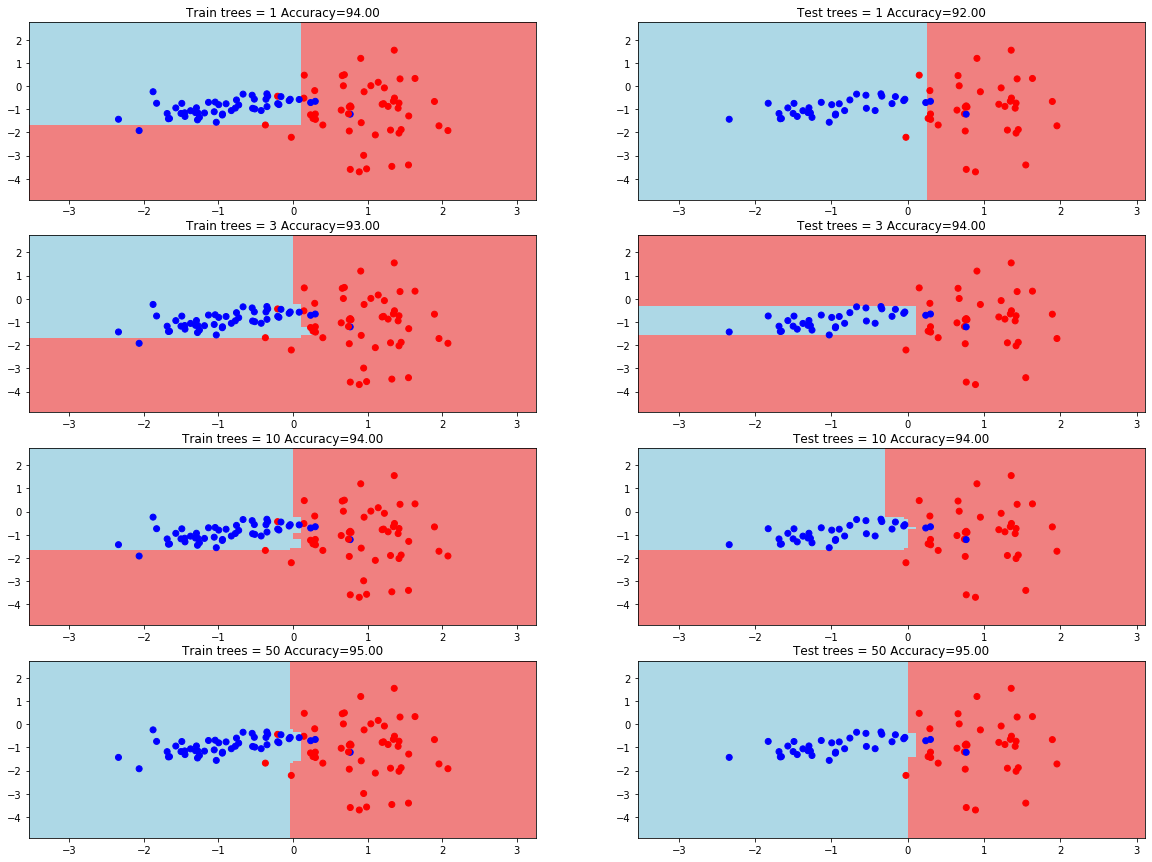

In [5]:
plt.figure(figsize = (20, 15))

plt.subplot(4,2,1)
train_chart(classification_data, classification_labels, 1, plt)

plt.subplot(4,2,2)
test_chart(classification_data, classification_labels, 1, plt)

plt.subplot(4,2,3)
train_chart(classification_data, classification_labels, 3, plt)

plt.subplot(4,2,4)
test_chart(classification_data, classification_labels, 3, plt)

plt.subplot(4,2,5)
train_chart(classification_data, classification_labels, 10, plt)

plt.subplot(4,2,6)
test_chart(classification_data, classification_labels, 10, plt)

plt.subplot(4,2,7)
train_chart(classification_data, classification_labels, 50, plt)

plt.subplot(4,2,8)
test_chart(classification_data, classification_labels, 50, plt)

__Вывод: похоже, что оптимальным вариантом является 3 дерева, т.к. в остальных модель переобучивается, судя по подстраиванию гиперплоскостей под исходные данные.__

__2. Заменить в реализованном алгоритме проверку с помощью отложенной выборки на Out-of-Bag.__

In [6]:
def get_bootstrap_oob(data, labels, N):
    n_samples = data.shape[0]
    bootstrap = []
    for i in range(N):
        oob_ind = []
        oob_ind.extend(range(0, n_samples))
        b_data = np.zeros(data.shape)
        b_labels = np.zeros(labels.shape)
        
        for j in range(n_samples):
            sample_index = random.randint(0, n_samples-1)
            if sample_index in oob_ind:
                oob_ind.remove(sample_index)
            b_data[j] = data[sample_index]
            b_labels[j] = labels[sample_index]

        bootstrap.append((b_data, b_labels, oob_ind))

    return bootstrap

def random_forest_oob(data, labels, n_trees):
    forest = []
    bootstrap = get_bootstrap_oob(data, labels, n_trees)
    for b_data, b_labels, oob_ind in bootstrap:
        forest.append((build_tree(b_data, b_labels), oob_ind))
    return forest

def tree_vote_oob(forest, data, labels):
    predictions = []

    o_err = {}
    for item in forest:
        tree, oob_ind = item
        oob_predict = predict(data[oob_ind], tree)
        for i in range(len(oob_ind)):
            k = oob_ind[i]
            if k not in o_err:
                o_err[k] = {"true": labels[k], "pred": []}
            o_err[k]['pred'].append(oob_predict[i])
        
        predictions.append(predict(data, tree))

    correct = 0
    for i in o_err:
        pred = o_err[i]['pred']
        correct += int(o_err[i]['true'] == max(set(pred), key=pred.count))
    
    predictions_per_object = list(zip(*predictions))
    voted_predictions = []
    for obj in predictions_per_object:
        voted_predictions.append(max(set(obj), key=obj.count))
    return voted_predictions, 1-correct/len(o_err)

In [7]:
forest = random_forest_oob(classification_data, classification_labels, 3)
answers, oob_error = tree_vote_oob(forest, classification_data, classification_labels)
accuracy_metric(classification_labels, answers)
oob_error

0.07999999999999996

__3. (На повторение) Переписать функцию calc_gini из урока про решающие деревья так, чтобы в качестве критерия использовалась энтропия Шэннона. Переименовать функцию в calc_entropy.__

In [8]:
def calc_entropy(labels):
    #  подсчет количества объектов разных классов
    classes = {}
    for label in labels:
        if label not in classes:
            classes[label] = 0
        classes[label] += 1

    #  расчет критерия
    impurity = 0
    for label in classes:
        p = classes[label] / len(labels)
        impurity -= p * np.log2(p)
        
    return impurity

In [9]:
calc_entropy(train_labels[:10])

0.8812908992306927